## A model for nonmass enhancement networks:

In [1]:
import pandas as pd
import numpy as np
import os
import os.path
import shutil
import glob
import tempfile
import subprocess
import SimpleITK as sitk

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams.update({'font.size': 8})

import numpy.ma as ma
from skimage.measure import find_contours, approximate_polygon
from scipy.spatial import Delaunay
from matplotlib.collections import LineCollection

# to save graphs
import six.moves.cPickle as pickle
import gzip
import networkx as nx
from skimage.morphology import skeletonize, skeletonize_3d
from scipy.linalg import det

import logging

from query_localdatabase import *
from run_cad_pipeline_fdicoms import *

# Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'24', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'fontname':'Arial', 'size':'16'}

In [2]:
data_loc = 'Z:\\Cristina\\Section3\\breast_MR_NME_pipeline'
processed_path = r'Z:\Cristina\Section3\breast_MR_NME_pipeline\processed_data' ##r'E:\Users\DeepLearning\outputs' ##
mha_data_loc= 'Z:\\Cristina\\Section3\\mha'

path_rootFolder = 'Z:\\Cristina\\Section3\\breast_MR_NME_biological'# os.path.dirname(os.path.abspath(__file__)) #
processed_NMEs_path = r'Z:\Cristina\Section3\breast_MR_NME_biological\processed_NMEs'

lesion_id = 1
localdata = Querylocaldb()
dflesion  = localdata.querylocalDatabase_wRad(lesion_id)      
cond = dflesion[0]
lesion_record = dflesion[1]
roi_record = dflesion[2]
nmlesion_record = dflesion[3]
StudyID = lesion_record['cad_pt_no_txt']
AccessionN = lesion_record['exam_a_number_txt']
DynSeries_id = nmlesion_record['DynSeries_id']  
roi_id = roi_record['roi_id']
label = roi_record['roi_label']
c = roi_record['roi_centroid']
centroid = c[c.find("(")+1:c.find(")")].split(',')
zslice = int(roi_record['zslice'])
p1 = roi_record['patch_diag1']
patch_diag1 = p1[p1.find("(")+1:p1.find(")")].split(',')
patch_diag1 = [float(p) for p in patch_diag1]
p2 = roi_record['patch_diag2']
patch_diag2 = p2[p2.find("(")+1:p2.find(")")].split(',')
patch_diag2 = [float(p) for p in patch_diag2]    

print("====================")
print('StudyID: ', StudyID)
print('AccessionN: ', AccessionN)
print('DynSeries_id: ', DynSeries_id)
print('label: ', label)
print("====================")

Executing local connection...
NON-MASS
----------------------------------------------------------

('StudyID: ', u'0002')
('AccessionN: ', u'6745896')
('DynSeries_id: ', u'800')
('label: ', u'M')


E:\Users\DeepLearning\Anaconda2\Lib\site-packages\sqlalchemy\sql\sqltypes.py:562: SAWarning: Dialect sqlite+pysqlite does *not* support Decimal objects natively, and SQLAlchemy must convert from floating point - rounding errors and other issues may occur. Please consider storing Decimal numbers as strings or integers on this platform for lossless storage.
  'storage.' % (dialect.name, dialect.driver))


In [3]:
#############################
###### 1) Accesing mc images and lesion prob maps
#############################
# get dynmic series info
precontrast_id = int(DynSeries_id) 
DynSeries_nums = [str(n) for n in range(precontrast_id,precontrast_id+5)]

print "Reading MRI volumes..."
DynSeries_imagefiles = []
mriVols = []
preCon_filename = '{}_{}_{}'.format(int(StudyID.zfill(4)),AccessionN,DynSeries_nums[0] )
glob_result = glob.glob(os.path.join(mha_data_loc,preCon_filename+'@*')) #'*':do not to know the exactly acquistion time
if glob_result != []:
    filename = glob_result[0]
# read Volumnes
DynSeries_imagefiles.append(filename)
mriVolDICOM = sitk.ReadImage(filename)
mriVols.append( sitk.GetArrayFromImage(sitk.Cast(mriVolDICOM,sitk.sitkFloat32)) )
mriVolSize = mriVolDICOM.GetSize()
print "MRI volumes Size = [%f,%f,%f]..." % mriVolSize
mriVolSpacing = mriVolDICOM.GetSpacing()
print "MRI volumes spacing = [%f,%f,%f]..." % mriVolSpacing
mriVolVoxratio = mriVolSpacing[2]/mriVolSpacing[0]        

for j in range(1,5):
    #the output mha:lesionid_patientid_access#_series#@acqusionTime.mha
    DynSeries_filename = '{}_{}_{}'.format(StudyID.zfill(4),AccessionN,DynSeries_nums[j] )

    #write log if mha file not exist             
    glob_result = glob.glob(os.path.join(processed_path,DynSeries_filename+'@*')) #'*':do not to know the exactly acquistion time
    if glob_result != []:
        filename = [name for name in glob_result if '_mc' in name][0] #glob_result[0]
        print filename

    # add side info from the side of the lesion
    DynSeries_imagefiles.append(filename)

    # read Volumnes
    mriVolDICOM = sitk.ReadImage(filename)
    mriVols.append( sitk.GetArrayFromImage(sitk.Cast(sitk.ReadImage(DynSeries_imagefiles[j]),sitk.sitkFloat32)) )


Reading MRI volumes...
MRI volumes Size = [512.000000,512.000000,88.000000]...
MRI volumes spacing = [0.429700,0.429700,3.000000]...
Z:\Cristina\Section3\breast_MR_NME_pipeline\processed_data\0002_6745896_801@082820_mc.mha
Z:\Cristina\Section3\breast_MR_NME_pipeline\processed_data\0002_6745896_802@083001_mc.mha
Z:\Cristina\Section3\breast_MR_NME_pipeline\processed_data\0002_6745896_803@083142_mc.mha
Z:\Cristina\Section3\breast_MR_NME_pipeline\processed_data\0002_6745896_804@083322_mc.mha


In [4]:
print "Reading probability map... and define ROI"
probmap_filename = '{}_{}_lesion_segmentation_probability.mha'.format(StudyID.zfill(4),AccessionN)
probmap_filepath = os.path.join(processed_path,probmap_filename)
probmap = sitk.GetArrayFromImage(sitk.Cast( sitk.ReadImage(probmap_filepath), sitk.sitkFloat32)) 

mx_query = np.zeros(probmap.shape)
ext_x = [int(ex) for ex in [np.min([patch_diag1[0],patch_diag2[0]])-10,np.max([patch_diag1[0],patch_diag2[0]])+10] ] 
ext_y = [int(ey) for ey in [np.min([patch_diag1[1],patch_diag2[1]])-10,np.max([patch_diag1[1],patch_diag2[1]])+10] ] 
mx_query[zslice-2:zslice+2, ext_x[0]:ext_x[1], ext_y[0]:ext_y[1]] = 1


Reading probability map... and define ROI


## Node Formation is based on enhancement boundary and center line:

### Model Assumptions:
    1) The higher the probability of lesion detection, the higher the likelihood that the region of enhancement contains nodes that belong to the enhancement network
    
* Nodes are located at the boundary of the weighted probability image (mask generated with a threshold > 99 percentile)
* Nodeas are located at the skeleton or (topological skeleton) which is a thin version of the lesion that is equidistant to its boundaries. 

In [5]:
# masked wsubvol1 nby probabilities
vol1 = mriVols[1][zslice,:,:]
vol2 = mriVols[2][zslice,:,:]
vol3 = mriVols[3][zslice,:,:]
vol4 = mriVols[4][zslice,:,:]

wvol1 = probmap[zslice,:,:]*vol1
wvol2 = probmap[zslice,:,:]*vol2
wvol3 = probmap[zslice,:,:]*vol3
wvol4 = probmap[zslice,:,:]*vol4

wvols = [wvol1,wvol2,wvol3,wvol4]

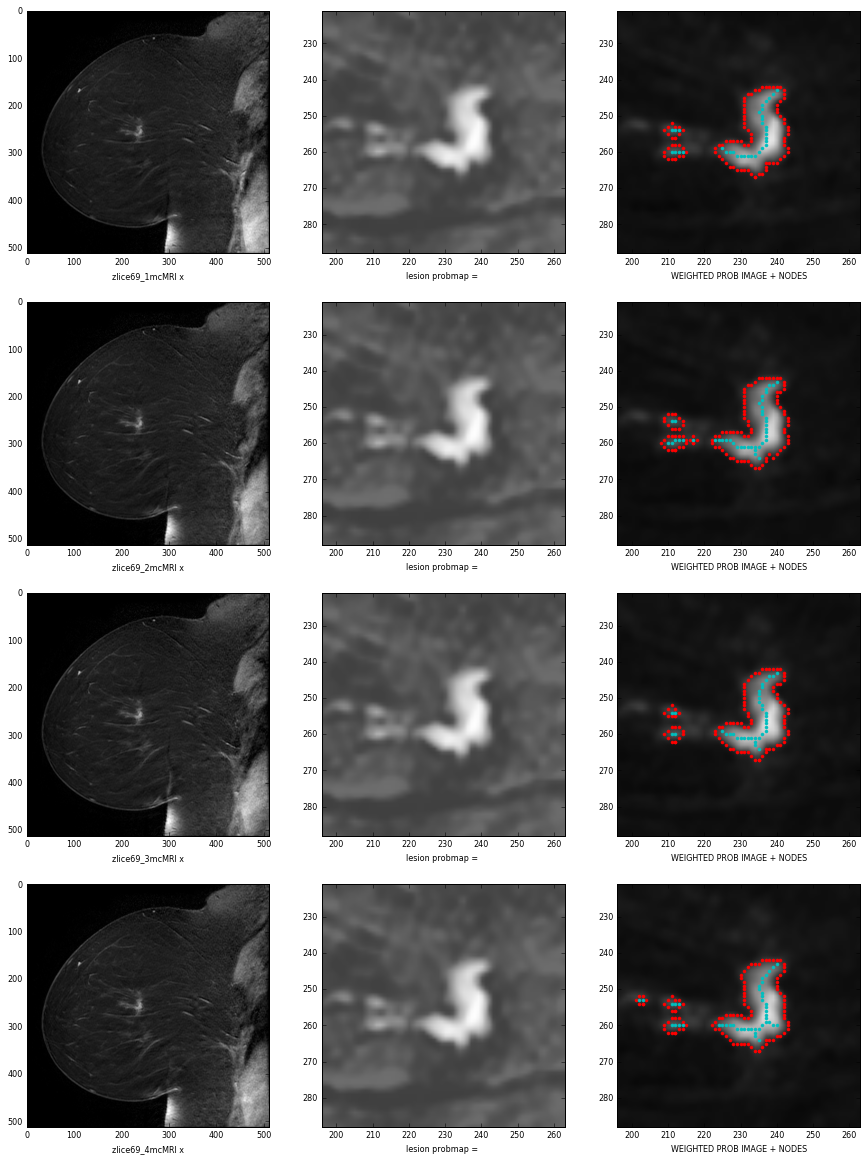

In [6]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(15, 20))
for k in range(1,5):
    ax[k-1,0].imshow(mriVols[k][zslice,:,:], cmap=plt.cm.gray)
    ax[k-1,0].set_adjustable('box-forced')
    ax[k-1,0].set_xlabel('zlice'+str(zslice+1)+'_'+str(k)+'mcMRI x')
    
    ax[k-1,1].imshow(probmap[zslice,:,:], cmap=plt.cm.gray)
    ax[k-1,1].axis((ext_y[0], ext_y[1], ext_x[1], ext_x[0]))
    ax[k-1,1].set_xlabel('lesion probmap = ')
    
    ax[k-1,2].imshow(wvols[k-1], cmap=plt.cm.gray)
    ax[k-1,2].axis((ext_y[0], ext_y[1], ext_x[1], ext_x[0]))
    ax[k-1,2].set_xlabel('WEIGHTED PROB IMAGE + NODES')
    
# to collect allcoords_wv
allcoords_wv = []
allcoords_wprob = []
for kw,wvol in enumerate(wvols):
    cuts = np.percentile(wvol, 99)
    mx_seg_lesion = ma.masked_array(np.zeros( wvol.shape ), mask=wvol>cuts)
    wv_masked_seg_lesion = ma.filled(mx_seg_lesion, fill_value=1.0)
    # Using the “marching squares” method to compute a the iso-valued contours 
    outlines_probmap = find_contours(wv_masked_seg_lesion, 0)
    coords_probmap = []
    for oi, outline in enumerate(outlines_probmap):
        #cords_redc = approximate_polygon(outline, tolerance=0.05)                
        inside = np.asarray([ext_x[0]<cr[0]<ext_x[1] and ext_y[0]<cr[1]<ext_y[1] for cr in outline]).any()
        if(inside):
            coords_probmap.append( outline )
            # plot
            ax[kw,2].plot(outline[:, 1], outline[:, 0], '.r', linewidth=1)
            
    # perform skeletonization
    wv_skeleton = skeletonize(wv_masked_seg_lesion.astype(bool))       
    # find points in the skeleton
    coords_wv_skeleton = np.column_stack(np.where(wv_skeleton))
    inside = np.asarray([ext_x[0]<cr[0]<ext_x[1] and ext_y[0]<cr[1]<ext_y[1] for cr in coords_wv_skeleton])
    coords_wv_skeleton = coords_wv_skeleton[inside]
    ax[kw,2].plot(coords_wv_skeleton[:, 1], coords_wv_skeleton[:, 0], '.c', linewidth=1)

    # once collected append them all as a 2D array of points
    coords_probmap = np.vstack(([coords for coords in coords_probmap]))
    coords_wv_skeleton = np.vstack(([coords for coords in coords_wv_skeleton]))
    coords_wv = np.vstack((coords_probmap,coords_wv_skeleton))
    # for probabilities
    outline_wprob = [wvol[int(u),int(v)] for u,v in coords_probmap]
    skeleton_wprob = [wvol[int(u),int(v)] for u,v in coords_wv_skeleton]
    allcoords_wprob.append( np.hstack((outline_wprob,skeleton_wprob)) )
    allcoords_wv.append( coords_wv )    


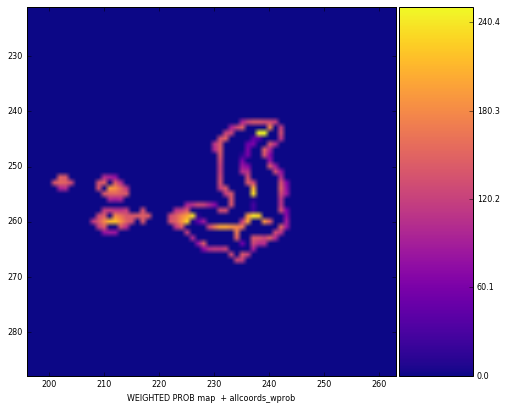

In [7]:
# append cords and Visualize the weighted probability values at the node locations
allcoords_wv = np.vstack(([coords for coords in allcoords_wv]))
allcoords_wprob = np.hstack(([coords for coords in allcoords_wprob]))
prob_img = np.zeros(mriVols[4][zslice,:,:].shape)
c=0
for u,v in allcoords_wv:
    prob_img[int(u),int(v)] = allcoords_wprob[c]
    c+=1

fig, ax = plt.subplots(figsize=(8, 8))
improb = ax.imshow(prob_img.astype('uint8'), cmap=plt.cm.plasma)
ax.set_adjustable('box-forced')
ax.set_xlabel('WEIGHTED PROB map  + allcoords_wprob')
ax.axis((ext_y[0], ext_y[1], ext_x[1], ext_x[0]))

v = np.linspace(min(prob_img.flatten()), max(prob_img.flatten()), 10, endpoint=True)     
divider = make_axes_locatable(ax)
caxEdges = divider.append_axes("right", size="20%", pad=0.05)
plt.colorbar(improb, cax=caxEdges, ticks=v) 
                

In [8]:
####################
### 1) Extract lesion SI/enhancement
####################    
mask_queryVols = []
onlyROI = []
for k in range(5):
    mx = ma.masked_array(mriVols[k], mask=mx_query==0)
    print "masked lesionVol_%i, lesion mean SI/enhancement = %f" % (k, mx.mean())
    mask_queryVols.append( ma.filled(mx, fill_value=None) )
    onlyROI.append( ma.compress_rowcols( mask_queryVols[k][zslice,:,:] ))

# Compute SI difference
rSIvols = []
for k in range(1,len(onlyROI)):
     rSIvols.append( onlyROI[k] - onlyROI[0] )
     print "lesion rSIvol_s%i, lesion mean realative SI/enhancement = %f" % (k, rSIvols[k-1].mean())

####################
# ROI network formation 
# get list of nodes       
allcoords_wv_redc = approximate_polygon(allcoords_wv, tolerance=0.01)      
allcoords_wv_redc.shape
nodepts = np.asarray( [allcoords_wv_redc[:, 1], allcoords_wv_redc[:, 0]]).transpose()
y = np.ascontiguousarray(nodepts).view(np.dtype((np.void, nodepts.dtype.itemsize * nodepts.shape[1])))
_, idx = np.unique(y, return_index=True)
unique_nodepts = nodepts[idx]
pts = [tuple(pi.flatten()) for pi in unique_nodepts]            


#############################
###### 1) Sample rSI at nodes
#############################
nodew = []
for node in pts:
    loc = tuple([int(loc) for loc in node])
    # find node location accros rSIvols
    rSIt = np.asarray([rSIvol[loc[1],loc[0]] for rSIvol in rSIvols])
    nodew.append( rSIt )

print 'nodeweights a total of {} computed...'.format(len(nodew))

#############################
###### 2) create placeholder for nx nodes
#############################                        
nodes = list(range(len(pts)))
# get original position of points
pos = dict(zip(nodes,pts))
# mapping from vertices to nodes
m = dict(enumerate(nodes)) 

#Create a graph
lesionG = nx.Graph() 
for i in range(len(pts)):
    # add position as node attributes
    lesionG.add_node(i, pos=pos[i])
    

masked lesionVol_0, lesion mean SI/enhancement = 90.945311
masked lesionVol_1, lesion mean SI/enhancement = 148.421391
masked lesionVol_2, lesion mean SI/enhancement = 154.002061
masked lesionVol_3, lesion mean SI/enhancement = 154.469272
masked lesionVol_4, lesion mean SI/enhancement = 155.905630
lesion rSIvol_s1, lesion mean realative SI/enhancement = 1.370107
lesion rSIvol_s2, lesion mean realative SI/enhancement = 1.521189
lesion rSIvol_s3, lesion mean realative SI/enhancement = 1.515801
lesion rSIvol_s4, lesion mean realative SI/enhancement = 1.580733
nodeweights a total of 152 computed...


## Link Formation is based on enhancemnt similarity modified by proximity between nodes:

The concept of a agraph or network of enhancement proposed is based on graph theory. A graph can be defined as some set of nodes $N$ and a set of links $L$ that represent relationships of proximal and distant areas of enhancement. For any two nodes $ni, nj \in N$, a relationship betwen them is defined as $\{ni, nj\} \in L$.

Node relationships are non-reflexive and undirected, since nodes are not related to themselves and relationships between nodes based on node similarity are independent of direction. This means that in the enhancement network, for any $\{ni,nj\} \in L, \{ni,nj\} == \{nj,ni\}$ and for any node $ni \in N, \{ni,ni\} \notin L$.



### Model Assumptions:
    1) The higher the similarity of enhancement at the nodes, the higher the likelihood that the nodes are connected in the network
    
    2) Link formation is based on an function of energy that represents similarity between nodes based on enhancemnt similarity modified by proximity. Thus, the energy between any two nodes 
    
    $ni, nj \in N$ can be defined as:

$$ E(\{ni,nj\} \in L)  = exp^{ -D(ni,nj)/G }*1/RMSD(ni,nj$$
  
where $D$ is a measure of pixel euclidean distance between node locations. D modifies the energy equation by increasing the energy when the nodes are proximal.

$ RMSD(ni,nj)$  is a measure of similarity. Similarity of enhancment can be measured by taking the root mean square distance between the four relative post-contrast enhancement at the node locations. Since the similarity metric must be high when the similarity of enhancement between points is high, we take the inverse of the RMSD so that the energy increases when RMSD is small

$G$ is a groweh factor that represents a sensitivity threshold for link formation. As $G$ increases, a fully unconnected network ($L=\empty$) will slowly grow until it is fully connected

Here different networks with different growth factors:

In [9]:
#############################
###### 4) Compute node similarity
#############################
D = np.zeros((len(nodes),len(nodes)))
RMSD_matrix = np.zeros((len(nodes),len(nodes)))
mask_edgew = np.triu(np.ones((len(nodew),len(nodew))))
for i in range(len(nodes)):
    for j in range(len(nodes)):
        if(mask_edgew[i,j]==1.0 and i!=j):
            RMSD = np.sqrt( np.sum(np.square(nodew[i] - nodew[j])) )   
            # append to matrix
            RMSD_matrix[i,j] = RMSD

            # calculate distance
            nipos = nx.get_node_attributes(lesionG,'pos')[i]
            njpos = nx.get_node_attributes(lesionG,'pos')[j]
            D_ij = np.sqrt(np.sum(np.square( np.asarray([d for d in nipos]) - np.asarray([d for d in njpos]) )))

            # append to matrix    
            D[i,j] = D_ij   

## Understanding the energy of linking ij

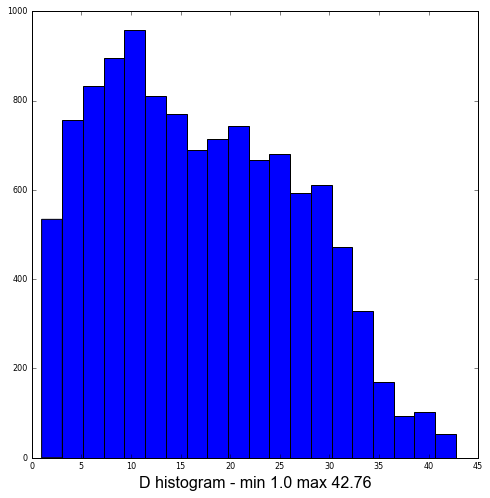

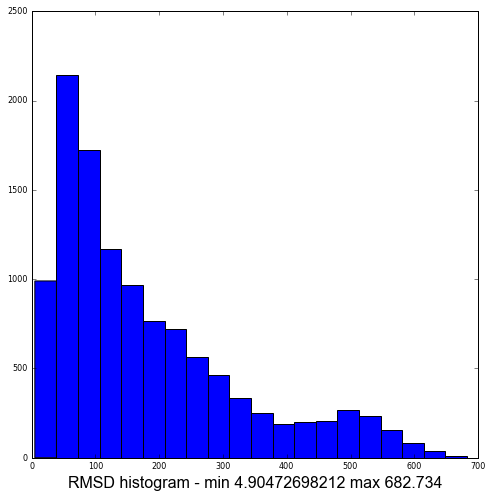

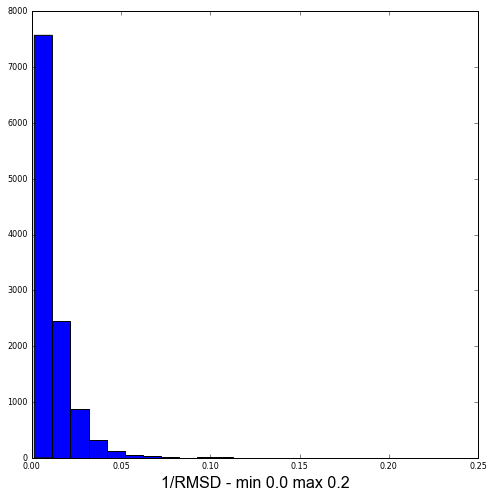

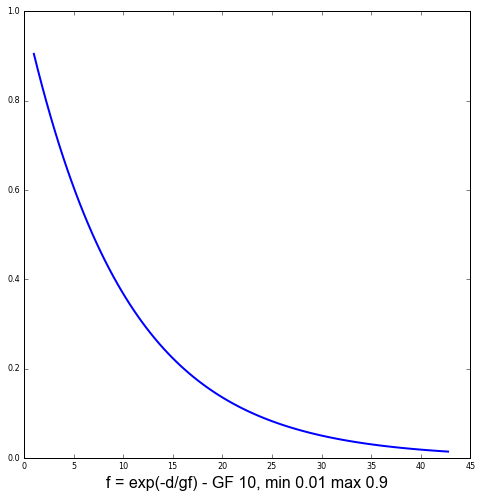

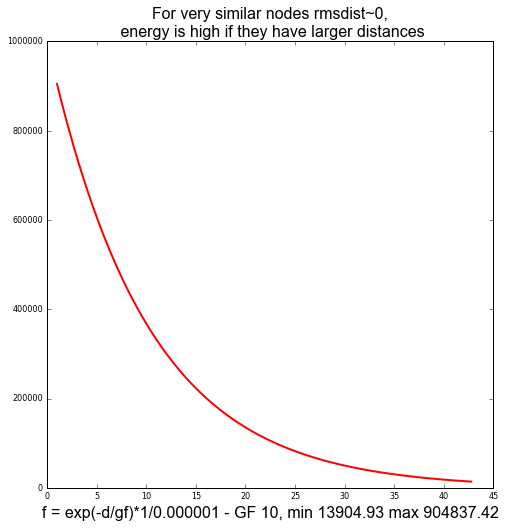

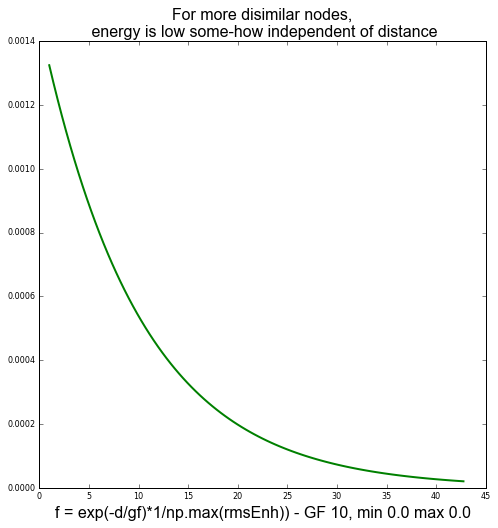

In [11]:
gf = 10
Ddist = D[np.triu_indices(D.shape[0], k=1)]           
rmsdist = RMSD_matrix[np.triu_indices(RMSD_matrix.shape[0], k=1)]

fig, ax = plt.subplots(figsize=(8,8), dpi=160)
N, bins, patches = ax.hist(Ddist, 20)
ax.set_xlabel('D histogram - min {} max {}'.format(round(np.min(Ddist), 2), round(np.max(Ddist), 2)),fontdict=axis_font)

fig, ax = plt.subplots(figsize=(8,8), dpi=160)
N, bins, patches = ax.hist(rmsdist, 20)
ax.set_xlabel('RMSD histogram - min {} max {}'.format(np.min(rmsdist), round(np.max(rmsdist), 3)),fontdict=axis_font)

fig, ax = plt.subplots(figsize=(8,8), dpi=160)
invrmsdist = [1.0/rms for rms in rmsdist if rms!=0]
N, bins, patches = ax.hist(invrmsdist, 20)
ax.set_xlabel('1/RMSD - min {} max {}'.format(round(np.min(invrmsdist), 2), round(np.max(invrmsdist), 2)),fontdict=axis_font)

# simulate functions
d = np.linspace(np.min(Ddist),np.max(Ddist),num=100)
rmsEnh = np.linspace(np.min(rmsdist),np.max(rmsdist),num=100)
y = np.exp(-d/gf)
fig, ax = plt.subplots(figsize=(8,8), dpi=160)
ax.plot(d, y,'b',linewidth=2)
ax.set_xlabel('f = exp(-d/gf) - GF {}, min {} max {}'.format(gf, round(np.min(y), 2), round(np.max(y), 2)),fontdict=axis_font)

y1 = np.exp(-d/gf)*1.0/0.000001
fig, ax = plt.subplots(figsize=(8,8), dpi=160)
ax.plot(d, y1,'r',linewidth=2)
ax.set_title('For very similar nodes rmsdist~0,\n energy is high if they have larger distances',fontdict=axis_font)
ax.set_xlabel('f = exp(-d/gf)*1/0.000001 - GF {}, min {} max {}'.format(gf, round(np.min(y1), 2), round(np.max(y1), 2)),fontdict=axis_font)

y2 = np.exp(-d/gf)*1.0/np.max(rmsEnh)
fig, ax = plt.subplots(figsize=(8,8), dpi=160)
ax.plot(d, y2,'g',linewidth=2)
ax.set_title('For more disimilar nodes,\n energy is low some-how independent of distance',fontdict=axis_font)
ax.set_xlabel('f = exp(-d/gf)*1/np.max(rmsEnh)) - GF {}, min {} max {}'.format(gf, round(np.min(y2), 2), round(np.max(y2), 2)),fontdict=axis_font)


## Understanding the effect of growth factor G:

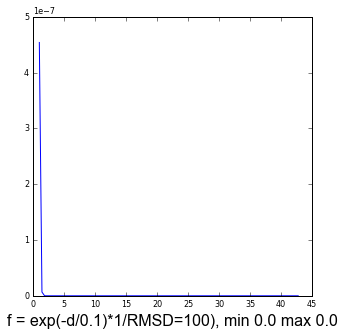

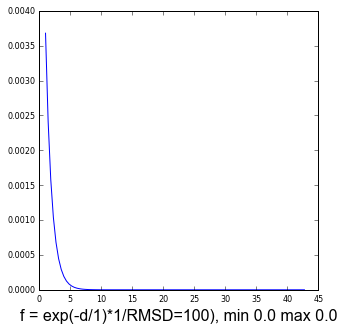

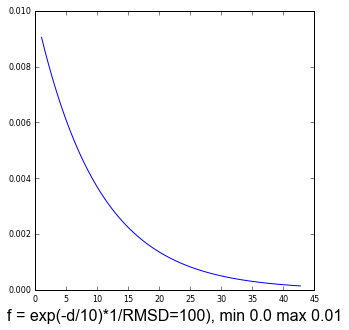

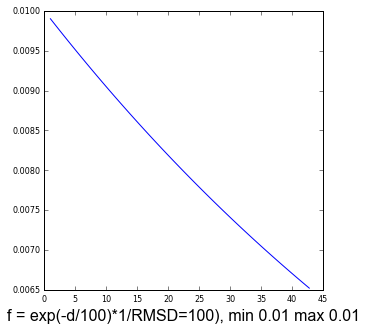

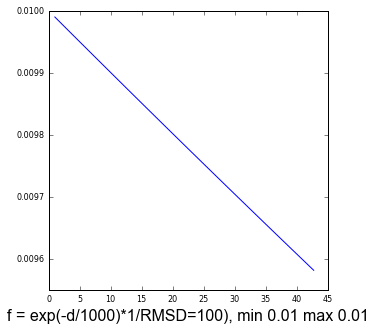

In [12]:
####################
gfs = [0.1,1,10,100,1000]  
for gf in gfs: 
    # Calculate the energy of linking ij
    #~~~~~~~ E({A,B}∈L)= e−D/gf * RMSD
    E_ij = np.exp(-D/gf)*1.0/RMSD_matrix

    d = np.linspace(np.min(Ddist),np.max(Ddist),num=100)
    rmsEnh = np.linspace(np.min(rmsdist),np.max(rmsdist),num=100)
    y = np.exp(-d/gf)*1.0/100
    
    fig, ax = plt.subplots(figsize=(5,5), dpi=160)
    ax.plot(d, y,'b')
    ax.set_xlabel('f = exp(-d/{})*1/RMSD=100), min {} max {}'.format(gf, round(np.min(y), 2), round(np.max(y), 2)),fontdict=axis_font)


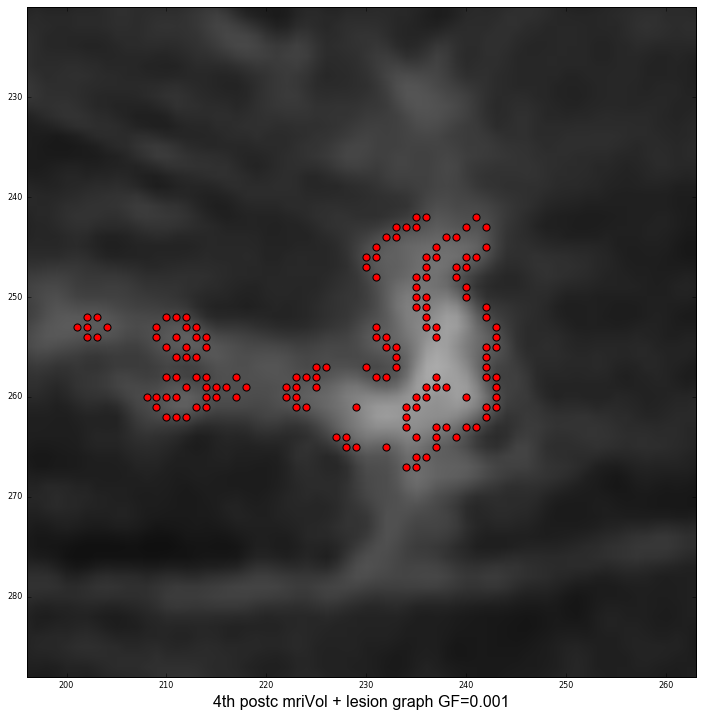

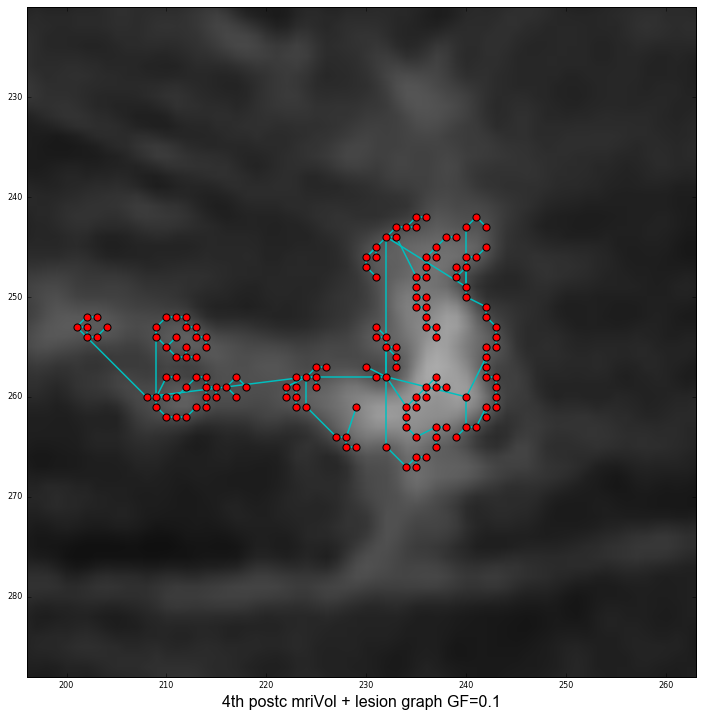

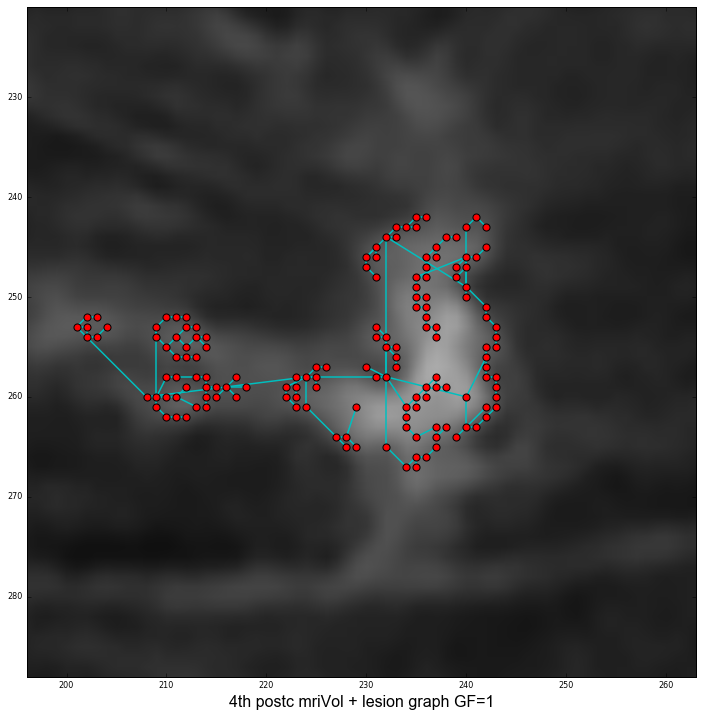

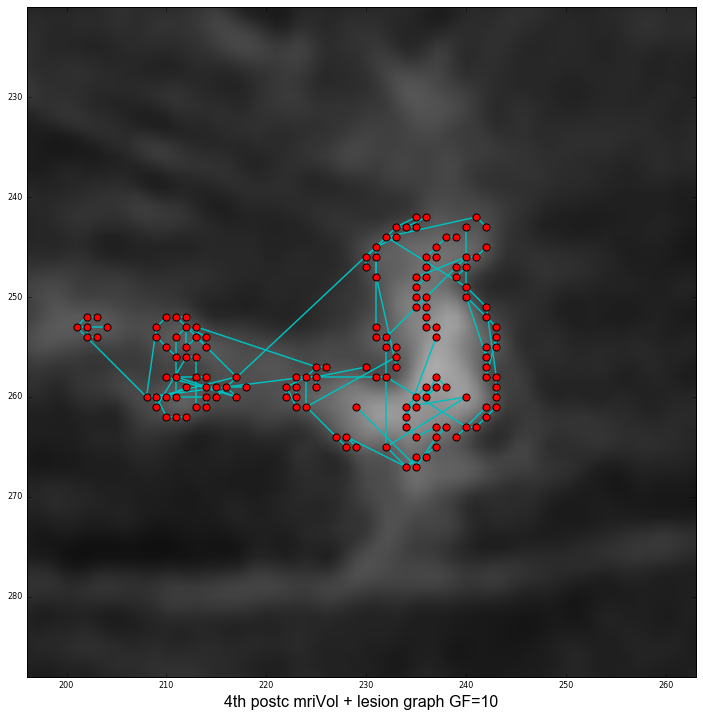

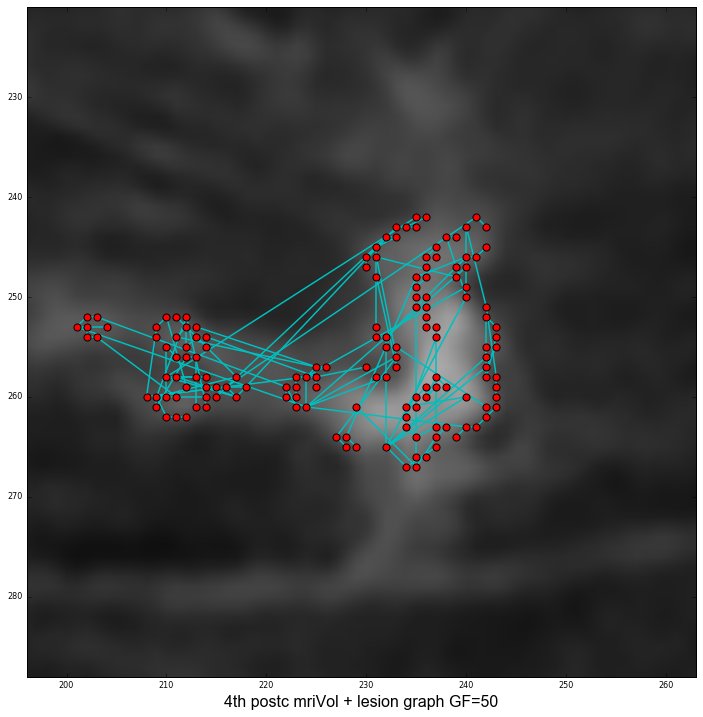

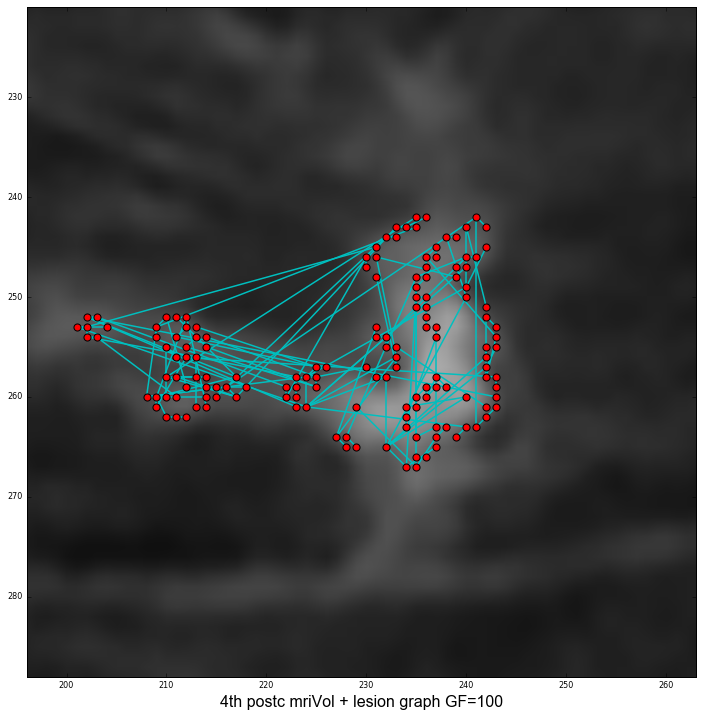

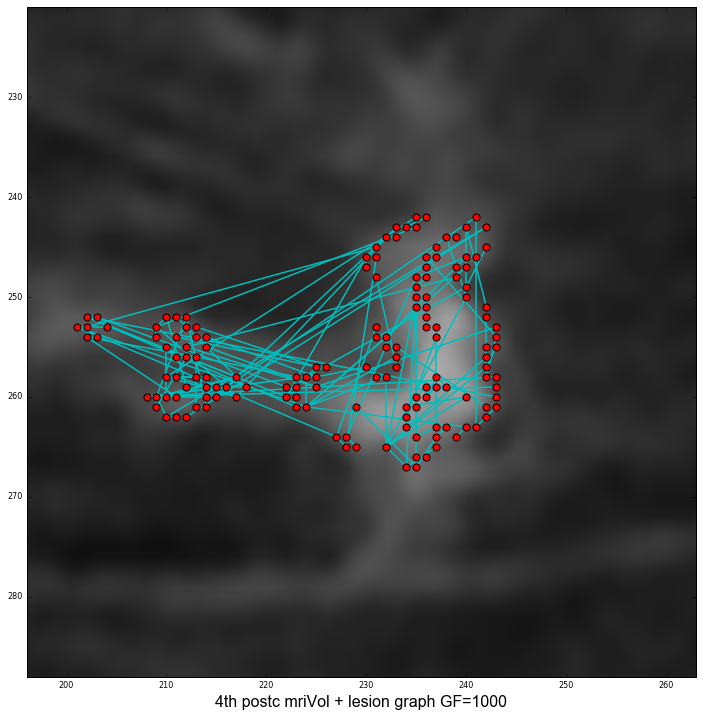

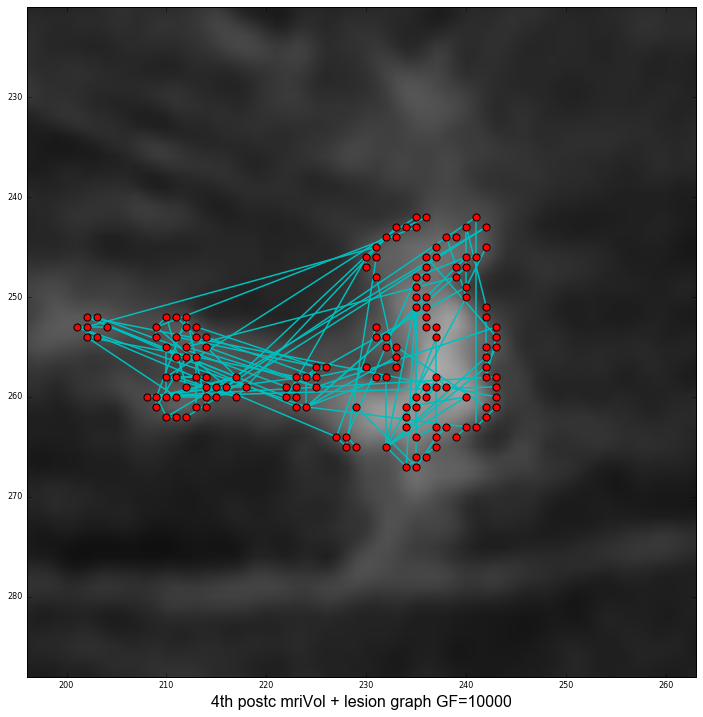

In [13]:
####################
# Calculate the energy of linking ij
#~~~~~~~ E({A,B}∈L)= e−D/gf * RMSD
gfs = [0.001,0.1,1,10,50,100,1000,10000]  
 
for gf in gfs:           
    E_ij = np.exp(-D/gf)*1.0/RMSD_matrix
    E_ij = np.triu( E_ij, k= 1 )
     
    #Create a graph
    lesionG = nx.Graph() 
    for i in range(len(pts)):
        # add position as node attributes
        lesionG.add_node(i, pos=pos[i])
    
    #############################
    ###### 5) Create links based on energy 
    #############################
    # add weights by topology but weighted by node similarity
    for i in range(len(nodes)): 
        if(np.max(E_ij[:,i]) != 0):
            highE_nodes = np.where(E_ij[:,i] == np.max(E_ij[:,i])) 
            for nE in highE_nodes[0]:
                lesionG.add_edge( nE, i, weight = E_ij[nE,i])  
    
    # PLOT
    fig, ax = plt.subplots(figsize=(12,12), dpi=160)
    # del graph
    ax.imshow(mriVols[4][zslice,:,:], cmap=plt.cm.gray)
    ax.set_adjustable('box-forced')
    ax.axis((ext_y[0], ext_y[1], ext_x[1], ext_x[0]))
    nx.draw_networkx(lesionG, pos, ax=ax, with_labels=False, node_color='r',node_size=50, linewidths=None, edge_color='c', width=1.5)
    ax.set_xlabel('4th postc mriVol + lesion graph GF='+str(gf),fontdict=axis_font)   

### Another case: disconected components

Executing local connection...
NON-MASS
----------------------------------------------------------

('StudyID: ', u'6263')
('AccessionN: ', u'7596102')
('DynSeries_id: ', u'600')
('label: ', u'U')
Reading MRI volumes...
MRI volumes Size = [512.000000,512.000000,80.000000]...
MRI volumes spacing = [0.390600,0.390600,3.000000]...
Z:\Cristina\Section3\breast_MR_NME_pipeline\processed_data\6263_7596102_601@091749_mc.mha
Z:\Cristina\Section3\breast_MR_NME_pipeline\processed_data\6263_7596102_602@091924_mc.mha
Z:\Cristina\Section3\breast_MR_NME_pipeline\processed_data\6263_7596102_603@092058_mc.mha
Z:\Cristina\Section3\breast_MR_NME_pipeline\processed_data\6263_7596102_604@092233_mc.mha
Reading probability map... and define ROI


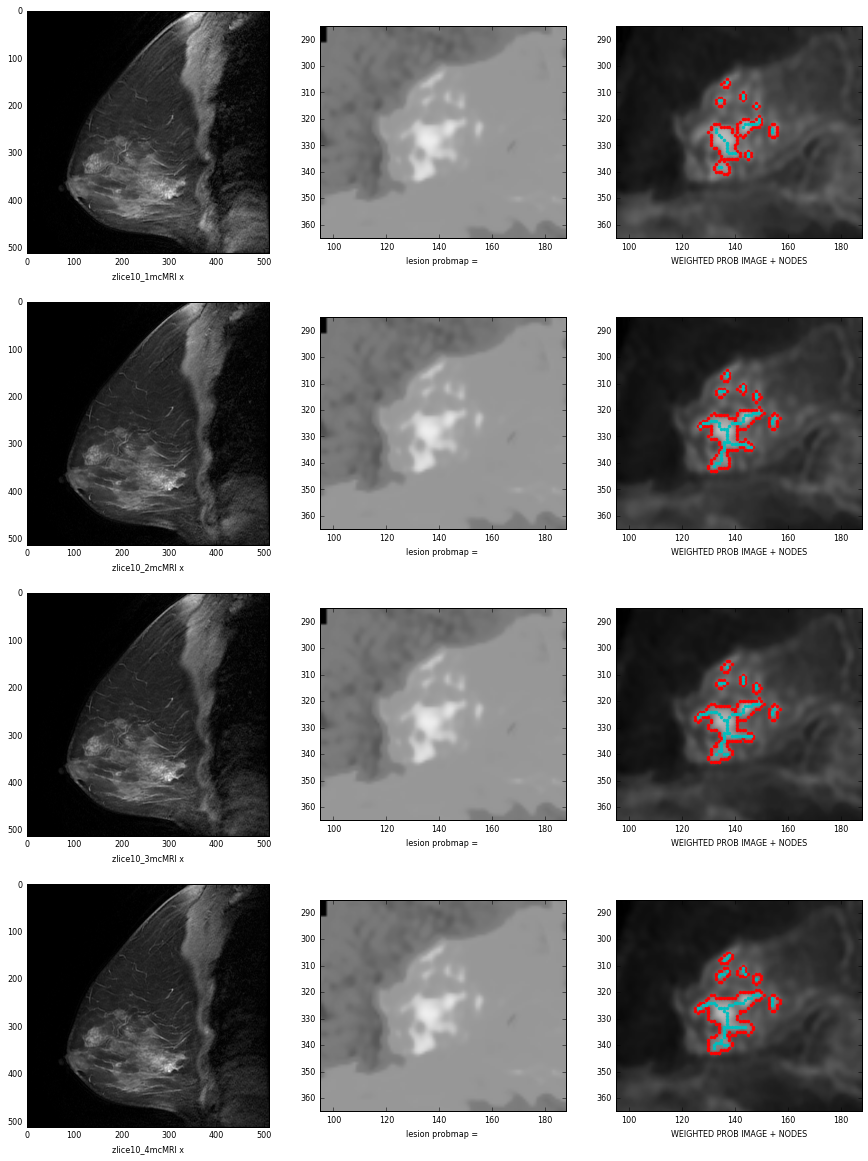

In [14]:
lesion_id = 1023
localdata = Querylocaldb()
dflesion  = localdata.querylocalDatabase_wRad(lesion_id)      
cond = dflesion[0]
lesion_record = dflesion[1]
roi_record = dflesion[2]
nmlesion_record = dflesion[3]
StudyID = lesion_record['cad_pt_no_txt']
AccessionN = lesion_record['exam_a_number_txt']
DynSeries_id = nmlesion_record['DynSeries_id']  
roi_id = roi_record['roi_id']
label = roi_record['roi_label']
c = roi_record['roi_centroid']
centroid = c[c.find("(")+1:c.find(")")].split(',')
zslice = int(roi_record['zslice'])
p1 = roi_record['patch_diag1']
patch_diag1 = p1[p1.find("(")+1:p1.find(")")].split(',')
patch_diag1 = [float(p) for p in patch_diag1]
p2 = roi_record['patch_diag2']
patch_diag2 = p2[p2.find("(")+1:p2.find(")")].split(',')
patch_diag2 = [float(p) for p in patch_diag2]    

print("====================")
print('StudyID: ', StudyID)
print('AccessionN: ', AccessionN)
print('DynSeries_id: ', DynSeries_id)
print('label: ', label)
print("====================")

#############################
###### 1) Accesing mc images and lesion prob maps
#############################
# get dynmic series info
precontrast_id = int(DynSeries_id) 
DynSeries_nums = [str(n) for n in range(precontrast_id,precontrast_id+5)]

print "Reading MRI volumes..."
DynSeries_imagefiles = []
mriVols = []
preCon_filename = '{}_{}_{}'.format(int(StudyID.zfill(4)),AccessionN,DynSeries_nums[0] )
glob_result = glob.glob(os.path.join(mha_data_loc,preCon_filename+'@*')) #'*':do not to know the exactly acquistion time
if glob_result != []:
    filename = glob_result[0]
# read Volumnes
DynSeries_imagefiles.append(filename)
mriVolDICOM = sitk.ReadImage(filename)
mriVols.append( sitk.GetArrayFromImage(sitk.Cast(mriVolDICOM,sitk.sitkFloat32)) )
mriVolSize = mriVolDICOM.GetSize()
print "MRI volumes Size = [%f,%f,%f]..." % mriVolSize
mriVolSpacing = mriVolDICOM.GetSpacing()
print "MRI volumes spacing = [%f,%f,%f]..." % mriVolSpacing
mriVolVoxratio = mriVolSpacing[2]/mriVolSpacing[0]        

for j in range(1,5):
    #the output mha:lesionid_patientid_access#_series#@acqusionTime.mha
    DynSeries_filename = '{}_{}_{}'.format(StudyID.zfill(4),AccessionN,DynSeries_nums[j] )

    #write log if mha file not exist             
    glob_result = glob.glob(os.path.join(processed_path,DynSeries_filename+'@*')) #'*':do not to know the exactly acquistion time
    if glob_result != []:
        filename = [name for name in glob_result if '_mc' in name][0] #glob_result[0]
        print filename

    # add side info from the side of the lesion
    DynSeries_imagefiles.append(filename)

    # read Volumnes
    mriVolDICOM = sitk.ReadImage(filename)
    mriVols.append( sitk.GetArrayFromImage(sitk.Cast(sitk.ReadImage(DynSeries_imagefiles[j]),sitk.sitkFloat32)) )

print "Reading probability map... and define ROI"
probmap_filename = '{}_{}_lesion_segmentation_probability.mha'.format(StudyID.zfill(4),AccessionN)
probmap_filepath = os.path.join(processed_path,probmap_filename)
probmap = sitk.GetArrayFromImage(sitk.Cast( sitk.ReadImage(probmap_filepath), sitk.sitkFloat32)) 

mx_query = np.zeros(probmap.shape)
ext_x = [int(ex) for ex in [np.min([patch_diag1[0],patch_diag2[0]])-10,np.max([patch_diag1[0],patch_diag2[0]])+10] ] 
ext_y = [int(ey) for ey in [np.min([patch_diag1[1],patch_diag2[1]])-10,np.max([patch_diag1[1],patch_diag2[1]])+10] ] 
mx_query[zslice-2:zslice+2, ext_x[0]:ext_x[1], ext_y[0]:ext_y[1]] = 1


# masked wsubvol1 nby probabilities
vol1 = mriVols[1][zslice,:,:]
vol2 = mriVols[2][zslice,:,:]
vol3 = mriVols[3][zslice,:,:]
vol4 = mriVols[4][zslice,:,:]

wvol1 = probmap[zslice,:,:]*vol1
wvol2 = probmap[zslice,:,:]*vol2
wvol3 = probmap[zslice,:,:]*vol3
wvol4 = probmap[zslice,:,:]*vol4

wvols = [wvol1,wvol2,wvol3,wvol4]

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(15, 20))
for k in range(1,5):
    ax[k-1,0].imshow(mriVols[k][zslice,:,:], cmap=plt.cm.gray)
    ax[k-1,0].set_adjustable('box-forced')
    ax[k-1,0].set_xlabel('zlice'+str(zslice+1)+'_'+str(k)+'mcMRI x')
    
    ax[k-1,1].imshow(probmap[zslice,:,:], cmap=plt.cm.gray)
    ax[k-1,1].axis((ext_y[0], ext_y[1], ext_x[1], ext_x[0]))
    ax[k-1,1].set_xlabel('lesion probmap = ')
    
    ax[k-1,2].imshow(wvols[k-1], cmap=plt.cm.gray)
    ax[k-1,2].axis((ext_y[0], ext_y[1], ext_x[1], ext_x[0]))
    ax[k-1,2].set_xlabel('WEIGHTED PROB IMAGE + NODES')
    
# to collect allcoords_wv
allcoords_wv = []
allcoords_wprob = []
for kw,wvol in enumerate(wvols):
    cuts = np.percentile(wvol, 99)
    mx_seg_lesion = ma.masked_array(np.zeros( wvol.shape ), mask=wvol>cuts)
    wv_masked_seg_lesion = ma.filled(mx_seg_lesion, fill_value=1.0)
    # Using the “marching squares” method to compute a the iso-valued contours 
    outlines_probmap = find_contours(wv_masked_seg_lesion, 0)
    coords_probmap = []
    for oi, outline in enumerate(outlines_probmap):
        #cords_redc = approximate_polygon(outline, tolerance=0.05)                
        inside = np.asarray([ext_x[0]<cr[0]<ext_x[1] and ext_y[0]<cr[1]<ext_y[1] for cr in outline]).any()
        if(inside):
            coords_probmap.append( outline )
            # plot
            ax[kw,2].plot(outline[:, 1], outline[:, 0], '.r', linewidth=1)
            
    # perform skeletonization
    wv_skeleton = skeletonize(wv_masked_seg_lesion.astype(bool))       
    # find points in the skeleton
    coords_wv_skeleton = np.column_stack(np.where(wv_skeleton))
    inside = np.asarray([ext_x[0]<cr[0]<ext_x[1] and ext_y[0]<cr[1]<ext_y[1] for cr in coords_wv_skeleton])
    coords_wv_skeleton = coords_wv_skeleton[inside]
    ax[kw,2].plot(coords_wv_skeleton[:, 1], coords_wv_skeleton[:, 0], '.c', linewidth=1)

    # once collected append them all as a 2D array of points
    coords_probmap = np.vstack(([coords for coords in coords_probmap]))
    coords_wv_skeleton = np.vstack(([coords for coords in coords_wv_skeleton]))
    coords_wv = np.vstack((coords_probmap,coords_wv_skeleton))
    # for probabilities
    outline_wprob = [wvol[int(u),int(v)] for u,v in coords_probmap]
    skeleton_wprob = [wvol[int(u),int(v)] for u,v in coords_wv_skeleton]
    allcoords_wprob.append( np.hstack((outline_wprob,skeleton_wprob)) )
    allcoords_wv.append( coords_wv )    


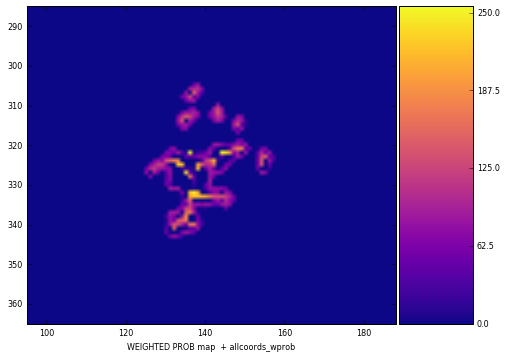

In [15]:
# append cords and Visualize the weighted probability values at the node locations
allcoords_wv = np.vstack(([coords for coords in allcoords_wv]))
allcoords_wprob = np.hstack(([coords for coords in allcoords_wprob]))
prob_img = np.zeros(mriVols[4][zslice,:,:].shape)
c=0
for u,v in allcoords_wv:
    prob_img[int(u),int(v)] = allcoords_wprob[c]
    c+=1

fig, ax = plt.subplots(figsize=(8, 8))
improb = ax.imshow(prob_img.astype('uint8'), cmap=plt.cm.plasma)
ax.set_adjustable('box-forced')
ax.set_xlabel('WEIGHTED PROB map  + allcoords_wprob')
ax.axis((ext_y[0], ext_y[1], ext_x[1], ext_x[0]))

v = np.linspace(min(prob_img.flatten()), max(prob_img.flatten()), 10, endpoint=True)     
divider = make_axes_locatable(ax)
caxEdges = divider.append_axes("right", size="20%", pad=0.05)
plt.colorbar(improb, cax=caxEdges, ticks=v) 
                

masked lesionVol_0, lesion mean SI/enhancement = 219.513878
masked lesionVol_1, lesion mean SI/enhancement = 271.349815
masked lesionVol_2, lesion mean SI/enhancement = 285.824530
masked lesionVol_3, lesion mean SI/enhancement = 296.716129
masked lesionVol_4, lesion mean SI/enhancement = 301.768548
lesion rSIvol_s1, lesion mean realative SI/enhancement = 1.186508
lesion rSIvol_s2, lesion mean realative SI/enhancement = 1.661215
lesion rSIvol_s3, lesion mean realative SI/enhancement = 2.050508
lesion rSIvol_s4, lesion mean realative SI/enhancement = 2.245770
nodeweights


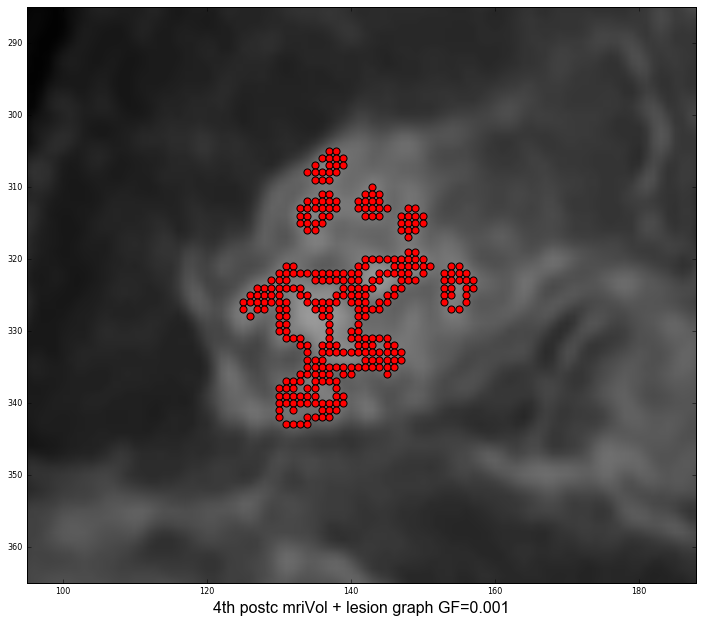

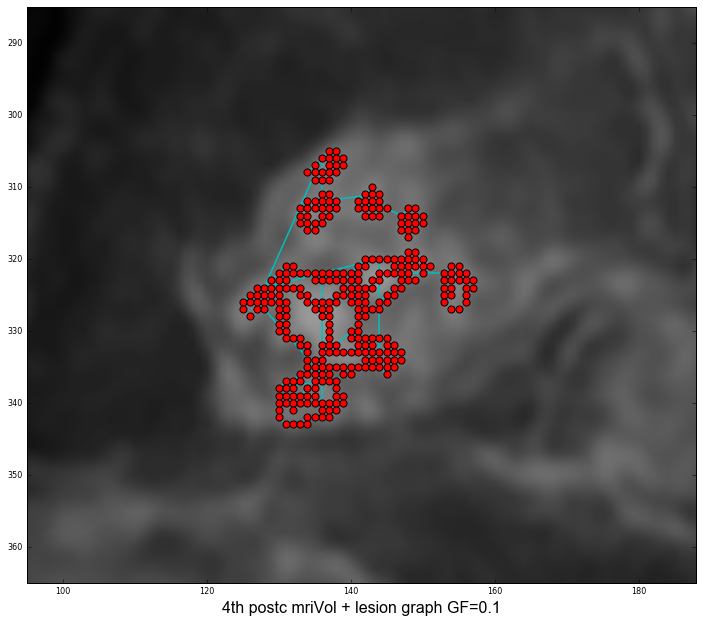

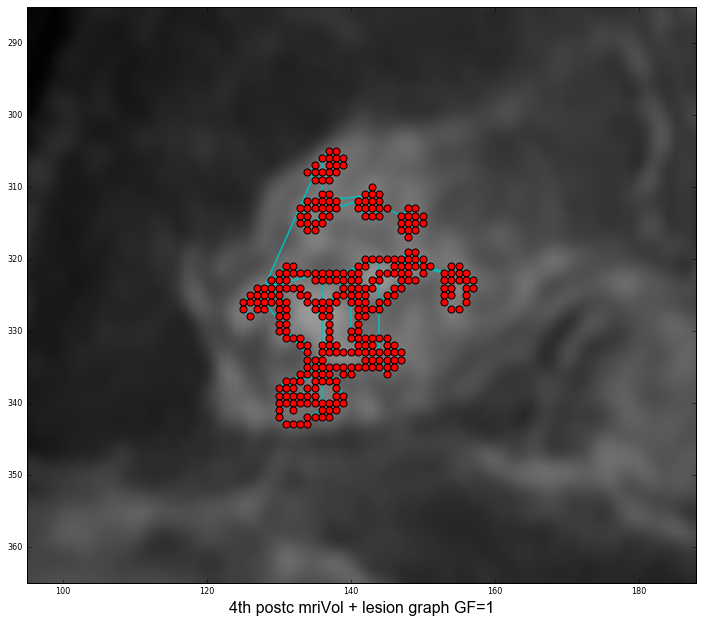

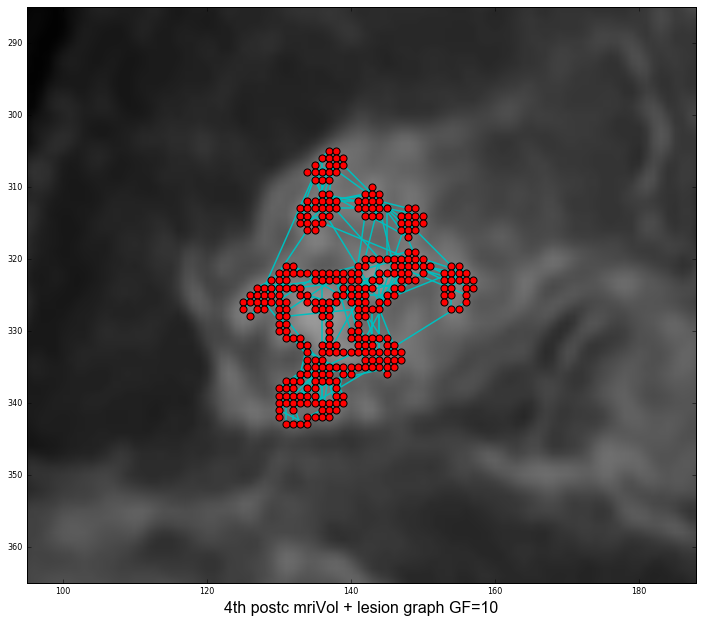

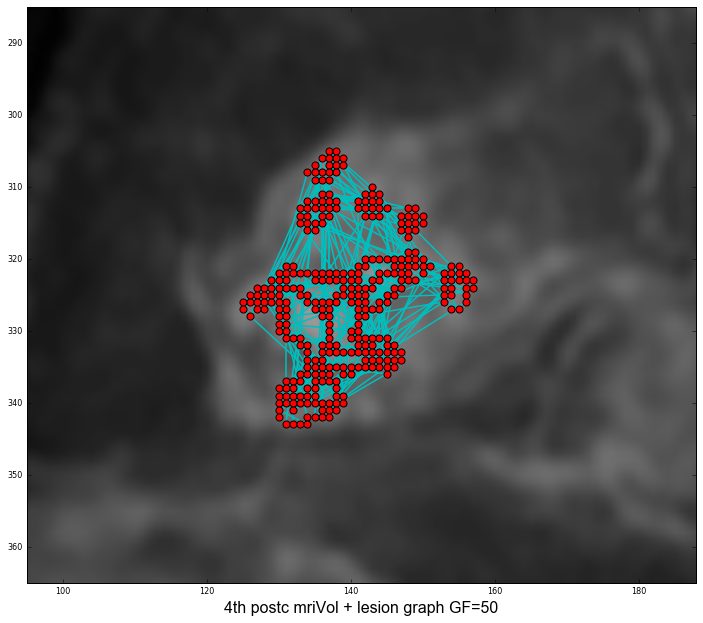

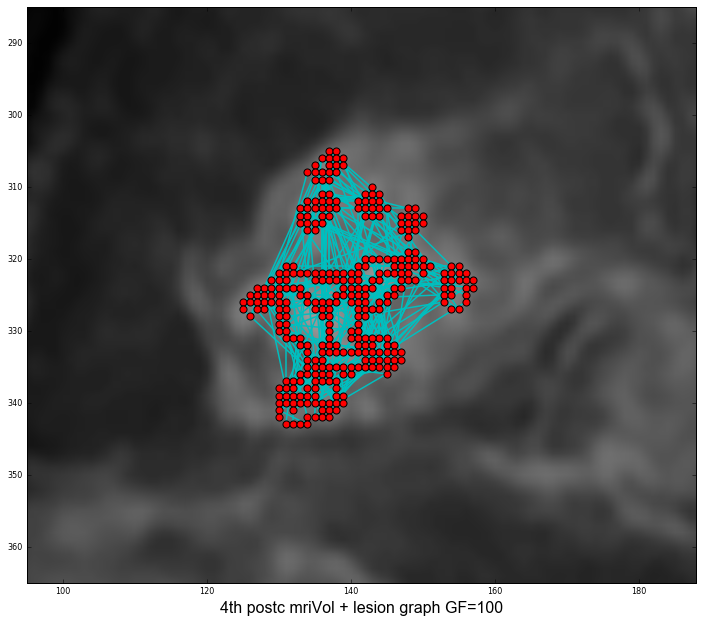

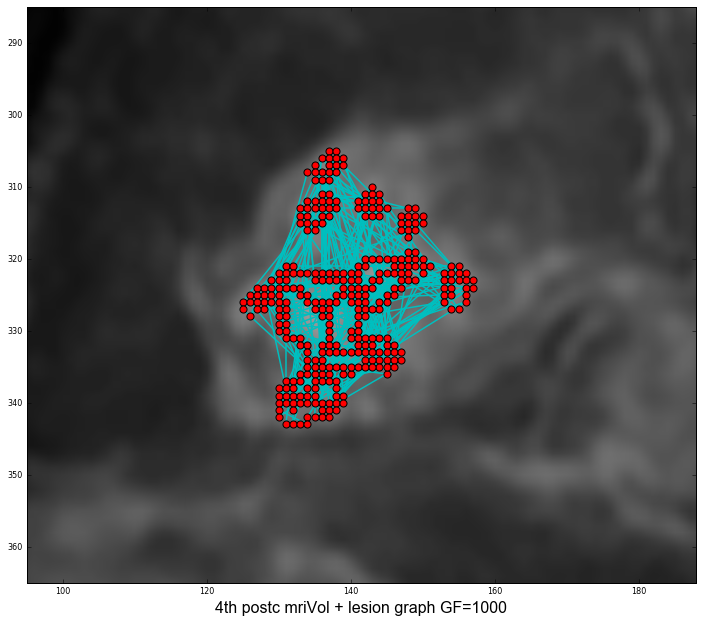

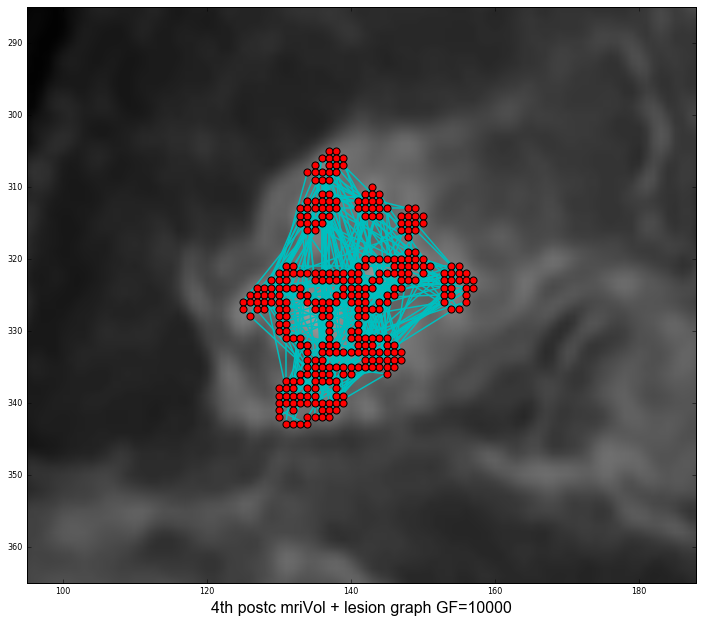

In [16]:
####################
### 1) Extract lesion SI/enhancement
####################    
mask_queryVols = []
onlyROI = []
for k in range(5):
    mx = ma.masked_array(mriVols[k], mask=mx_query==0)
    print "masked lesionVol_%i, lesion mean SI/enhancement = %f" % (k, mx.mean())
    mask_queryVols.append( ma.filled(mx, fill_value=None) )
    onlyROI.append( ma.compress_rowcols( mask_queryVols[k][zslice,:,:] ))

# Compute SI difference
rSIvols = []
for k in range(1,len(onlyROI)):
     rSIvols.append( onlyROI[k] - onlyROI[0] )
     print "lesion rSIvol_s%i, lesion mean realative SI/enhancement = %f" % (k, rSIvols[k-1].mean())

# ROI network formation 
# get list of nodes       
nodepts = np.asarray( [allcoords_wv[:, 1], allcoords_wv[:, 0]]).transpose()
y = np.ascontiguousarray(nodepts).view(np.dtype((np.void, nodepts.dtype.itemsize * nodepts.shape[1])))
_, idx = np.unique(y, return_index=True)
unique_nodepts = nodepts[idx]
pts = [tuple(pi.flatten()) for pi in unique_nodepts]            

#############################
###### 2) Sample rSI at nodes
#############################
nodew = []
print "nodeweights" 
for node in pts:
    loc = tuple([int(loc) for loc in node])
    # find node location accros rSIvols
    rSIt = np.asarray([rSIvol[loc[1],loc[0]] for rSIvol in rSIvols])
    nodew.append( rSIt )

#############################
###### 3) create placeholder for nx nodes
#############################                        
nodes = list(range(len(pts)))
# get original position of points
pos = dict(zip(nodes,pts))
# mapping from vertices to nodes
m = dict(enumerate(nodes)) 

#Create a graph
lesionG = nx.Graph() 
for i in range(len(pts)):
    # add position as node attributes
    lesionG.add_node(i, pos=pos[i])
    
#############################
###### 4) Compute node similarity
#############################
D = np.zeros((len(nodes),len(nodes)))
RMSD_matrix = np.zeros((len(nodes),len(nodes)))
mask_edgew = np.triu(np.ones((len(nodew),len(nodew))))
for i in range(len(nodes)):
    for j in range(len(nodes)):
        if(mask_edgew[i,j]==1.0 and i!=j):
            RMSD = np.sqrt( np.sum(np.square(nodew[i] - nodew[j])) )   
            # append to matrix
            RMSD_matrix[i,j] = RMSD

            # calculate distance
            nipos = nx.get_node_attributes(lesionG,'pos')[i]
            njpos = nx.get_node_attributes(lesionG,'pos')[j]
            D_ij = np.sqrt(np.sum(np.square( np.asarray([d for d in nipos]) - np.asarray([d for d in njpos]) )))

            # append to matrix    
            D[i,j] = D_ij   
            
            
####################
# Calculate the energy of linking ij
#~~~~~~~ E({A,B}∈L)= e−D/gf * RMSD
gfs = [0.001,0.1,1,10,50,100,1000,10000]  
 
for gf in gfs:           
    E_ij = np.exp(-D/gf)*1.0/RMSD_matrix
    E_ij = np.triu( E_ij, k= 1 )
     
    #Create a graph
    lesionG = nx.Graph() 
    for i in range(len(pts)):
        # add position as node attributes
        lesionG.add_node(i, pos=pos[i])
    
    #############################
    ###### 5) Create links based on energy 
    #############################
    # add weights by topology but weighted by node similarity
    for i in range(len(nodes)): 
        if(np.max(E_ij[:,i]) != 0):
            highE_nodes = np.where(E_ij[:,i] == np.max(E_ij[:,i])) 
            for nE in highE_nodes[0]:
                lesionG.add_edge( nE, i, weight = E_ij[nE,i])  
    
    # PLOT
    fig, ax = plt.subplots(figsize=(12,12), dpi=160)
    # del graph
    ax.imshow(mriVols[4][zslice,:,:], cmap=plt.cm.gray)
    ax.set_adjustable('box-forced')
    ax.axis((ext_y[0], ext_y[1], ext_x[1], ext_x[0]))
    nx.draw_networkx(lesionG, pos, ax=ax, with_labels=False, node_color='r',node_size=50, linewidths=None, edge_color='c', width=1.5)
    ax.set_xlabel('4th postc mriVol + lesion graph GF='+str(gf),fontdict=axis_font)   

## Growth factor value = 10
This value of five was empirically determined with several patient and tissue types.


# Network Analysis methods.
### Degree
The degree of a given node x is the number of links in L which contain it. The degree D(x) can be found as follows:

$$ D(x)= |\{ y \in N : \{x, y\} \in N\} | $$

Nodes with high degree are in more dense areas of enhancement and likely represent higher enhancement, but degree is dependent on cluster size. The degree of a node is very similar in many ways to clustering coefficient, as it provides information about the shape of the network and feedback for the threshold setting. An example is shown below, Nodes with high values for a particular method are highlighted (orange)

source: https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.centrality.degree_centrality.html#networkx.algorithms.centrality.degree_centrality

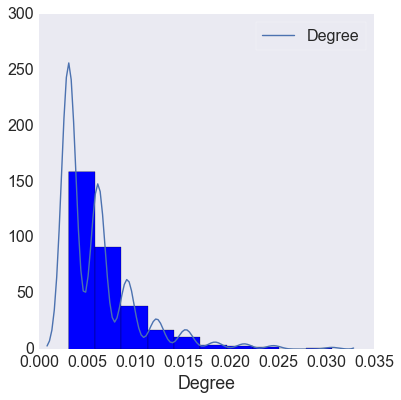

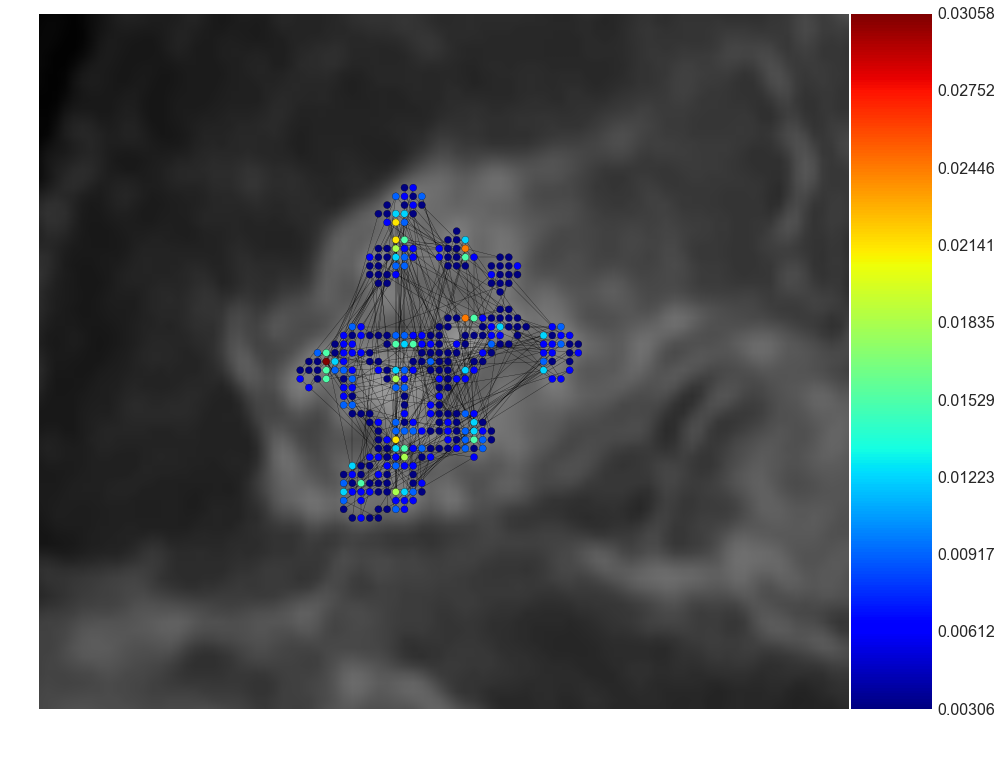

In [22]:
import seaborn as sns
sns.set_style("darkgrid", {'axes.grid' : False, "legend.frameon": True})
sns.set_context("paper", font_scale=2)              

Degree = nx.degree_centrality(lesionG) 
pd_Degree = pd.Series(Degree.values(), name="Degree")
fig, ax = plt.subplots(figsize=(6,6), dpi=160)
ax.hist(Degree.values(),color='b')
sns.distplot(pd_Degree, label="Degree", ax=ax, hist=False)

fig, ax = plt.subplots(figsize=(16,16), dpi=160)
ax.imshow(mriVols[4][zslice,:,:], cmap=plt.cm.gray)
Dvalues = np.asarray([Degree.get(node) for node in lesionG.nodes()])
v = np.linspace(min(Dvalues), max(Dvalues), 10, endpoint=True) 
nxg = nx.draw_networkx_nodes(lesionG, pos, ax=ax, node_color=Dvalues, cmap=plt.cm.jet,  
                 node_vmin=np.min(Dvalues), node_vmax=np.max(Dvalues),
                 with_labels=False, node_size=50)
nx.draw_networkx_edges(lesionG, pos, ax=ax,  width=0.25)
ax.axis((ext_y[0], ext_y[1], ext_x[1], ext_x[0]))
ax.set_axis_off()
ax.set_adjustable('box-forced')
ax.set_xlabel('Degree nodes')    
divider = make_axes_locatable(ax)
caxEdges = divider.append_axes("right", size="10%", pad=0.05)
plt.colorbar(nxg, cax=caxEdges, ticks=v) 


### Betweenness
Betweenness is part of centrality theory, and it is one measure of the importance of a particular node
to its cluster. Specifically, the Betweenness is the number of shortest paths that use that node s
over all the shortest paths between every node. Given the set of all shortest paths S 
(determined by Dijkstra’s algorithm), the betweenness B can be found as follows:
$$ B(x)= \frac{|s|}{|\mathbf{S}|}: x \in Q, Q \in S $$
    
High Betweenness would mean that a node is important to the structure of a network or
important in connecting two enahncing regions into one cluster.

source: https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.centrality.betweenness_centrality.html#networkx.algorithms.centrality.betweenness_centrality

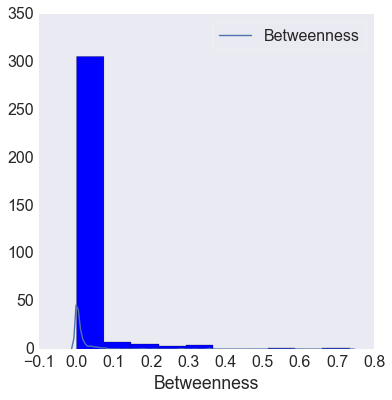

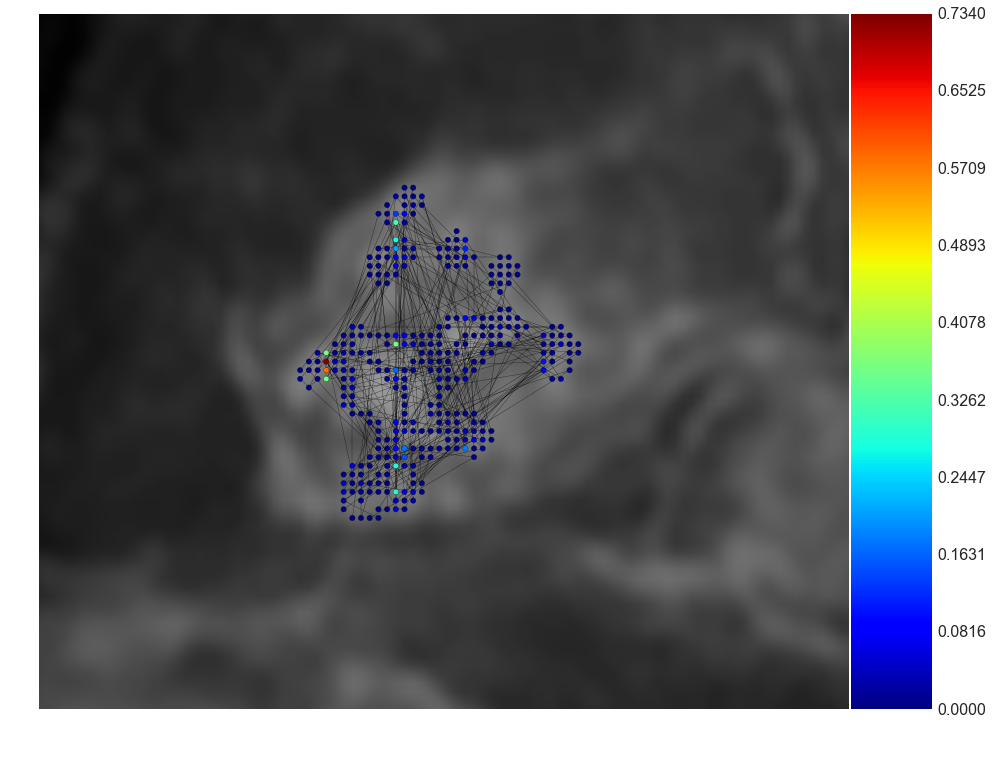

In [24]:
Betweenness = nx.betweenness_centrality(lesionG)
pd_Betweenness = pd.Series(Betweenness.values(), name="Betweenness")
fig, ax = plt.subplots(figsize=(6,6), dpi=160)
ax.hist(Betweenness.values(),color='b')
sns.distplot(pd_Betweenness, label="Betweenness", ax=ax, hist=False)

fig, ax = plt.subplots(figsize=(16,16), dpi=160)
ax.imshow(mriVols[4][zslice,:,:], cmap=plt.cm.gray)
Betweennessvalues = np.asarray([Betweenness.get(node) for node in lesionG.nodes()])
v = np.linspace(min(Betweennessvalues), max(Betweennessvalues), 10, endpoint=True) 
nxg = nx.draw_networkx_nodes(lesionG, pos, ax=ax, node_color=Betweennessvalues, cmap=plt.cm.jet,  
                 node_vmin=min(Betweennessvalues), node_vmax=max(Betweennessvalues),
                 with_labels=False, node_size=30)
nx.draw_networkx_edges(lesionG, pos, ax=ax,  width=0.25)
ax.axis((ext_y[0], ext_y[1], ext_x[1], ext_x[0]))
ax.set_axis_off()
ax.set_adjustable('box-forced')
ax.set_xlabel('Degree nodes')    
divider = make_axes_locatable(ax)
caxEdges = divider.append_axes("right", size="10%", pad=0.05)
plt.colorbar(nxg, cax=caxEdges, ticks=v) 


### Clustering Coefficient
Clustering coefficient is a measure of the transitivity of a node. 
Given some neighborhood N defined as:
$$ N(x)= \{y \in N : \{x, y\} \in L\}$$ 

The clustering coefficient C(x) can be found as:
$$ C(x)= \frac{2|\{y,z\}|}{D(x)*(D(x)−1)} : y, z \in N(x), \{y,z\} \in L$$ 
    
source: 
https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.approximation.clustering_coefficient.average_clustering.html#networkx.algorithms.approximation.clustering_coefficient.average_clustering